# MNIST with Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from tqdm import tqdm
import numpy as np

In [88]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout2d(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.drop1(x)
        x = self.pool2(x)
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = F.softmax(x, dim=1)
        return x

In [3]:
from torchvision.datasets import MNIST

mnist_train = MNIST("./mnist", train=True, download=True)
mnist_test = MNIST("./mnist", train=False, download=True)

# convert to numpy for my practice
x_train = mnist_train.train_data.numpy().reshape(-1,1,28,28)
x_train = np.asarray(x_train, dtype=np.float32)/255.0
y_train = mnist_train.train_labels.numpy() # not one-hot

x_test = mnist_test.test_data.numpy().reshape(-1,1,28,28)
x_test = np.asarray(x_test, dtype=np.float32)/255.0
y_test = mnist_test.test_labels.numpy()


train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [4]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def test(model, device, test_loader):
    correct = 0
    total_loss = 0
    crossentropy = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            total_loss += crossentropy(out, y).item() # detach the history
            _, pred = torch.max(out.data, 1)
            correct += (pred==y).sum().item()

    acc = correct/len(test_loader.dataset)
    loss = total_loss/len(test_loader.dataset)
    return acc, loss

def train(model, device, train_loader, test_loader, optimizer, n_epochs):
    crossentropy = nn.CrossEntropyLoss()
    train_loss = []
    test_loss = []

    for epoch in range(n_epochs):
        train_total_loss = 0
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = crossentropy(out, y)
            train_total_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss.append(train_total_loss / len(train_loader.dataset) )
        _, test_loss_ave = test(model, device, test_loader)
        test_loss.append(test_loss_ave)
        save_model(model, "model")

    return train_loss, test_loss

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(train_loss, test_loss):
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss)
    plt.plot(x, test_loss)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["train", "test"])

100%|██████████| 469/469 [00:01<00:00, 244.26it/s]


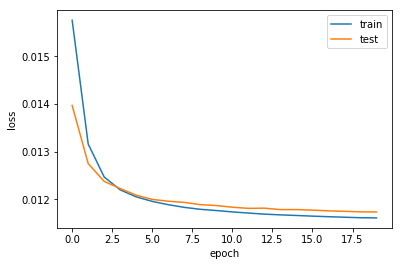

In [89]:
model = MyModel()
device = torch.device("cuda:0")
model = model.to(device)
adam = opt.Adam(model.parameters(), lr=0.00001)

train_loss, test_loss = train(model=model, device=device, train_loader=train_loader, test_loader=test_loader,
                              optimizer=adam, n_epochs=20)
plot_loss(train_loss, test_loss)

In [90]:
acc, _ = test(model, device, test_loader)
print("Accuracy:", acc)

Accuracy: 0.9803


In [75]:
# load saved model
m = MyModel()
m.load_state_dict(torch.load("model"))
m = m.to(device)
print(test(m, device, test_loader))

(0.9812, 0.011733883583545685)


In [21]:
# Export models with ONNX format
model_ex = model.cpu() # can't export the model on GPU
x_= torch.randn(128, 1, 28, 28) # dummy input is requred
torch.onnx._export(model_ex,x_,"model.onnx", export_params=True) 

tensor([[ 2.0341e-07,  2.0341e-07,  4.5214e-07,  ...,  2.0341e-07,
          2.4980e-05,  2.0341e-07],
        [ 7.7772e-06,  7.7772e-06,  2.6350e-01,  ...,  7.7772e-06,
          7.3636e-01,  7.7772e-06],
        [ 3.3785e-08,  3.3785e-08,  1.9098e-03,  ...,  3.3785e-08,
          8.9708e-08,  3.3785e-08],
        ...,
        [ 1.2176e-04,  4.2380e-02,  1.2176e-04,  ...,  1.2176e-04,
          5.2136e-03,  1.2176e-04],
        [ 1.1864e-05,  1.1864e-05,  5.7753e-01,  ...,  7.1061e-03,
          1.1864e-05,  1.1864e-05],
        [ 1.4044e-04,  1.4044e-04,  2.0889e-04,  ...,  1.4044e-04,
          6.5220e-01,  1.4044e-04]])